[    1  2401  5026  7427  7748 10661 13062 15943]
8
[   0  300  628  928  968 1332 1632 1992]


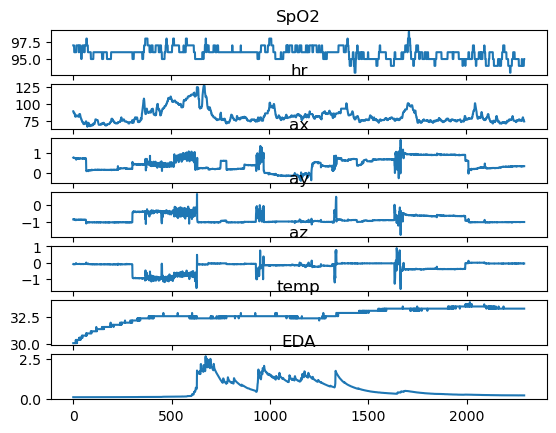

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import numpy as np
# this contains visualization of the data preprocessed data before quantification of intervals and training of models,
# for that, see cluster.ipynb
# for more information about the dataset, see https://doi.org/10.13026/C26Q2Z
# record_name = 'data/non-eeg-dataset/Subject1_SpO2HR'
# record_annotation_name = 'data/non-eeg-dataset/Subject1_AccTempEDA'
record_1_name = 'data/non-eeg-dataset/Subject1_SpO2HR'
record_2_name= 'data/non-eeg-dataset/Subject1_AccTempEDA'

annotation = wfdb.rdann(record_2_name, 'atr')

phases = annotation.sample / annotation.fs
print(annotation.sample)
print(annotation.fs) # how many samples per second. We divide by this to get the annotation timestamps in seconds
phases = phases.astype(int)
print(phases)
# relaxation = until time[1]
# physical = time[1] to time[2]
# relaxation = time[2] to time[3]
# emotional = time[3] to time[4]
# cognitive =  time[4] to time[5]
# recovery = time[5] to time[6]
# emotional(horror) = time[6] to time[7]
# relaxation = time[7] to end
record_1 = wfdb.rdrecord(record_1_name)
record_2 = wfdb.rdrecord(record_2_name)


# we want to downsample the data of record_2 to match the data of record_1. record_1 is 1Hz, record_2 is 8Hz
record_2_downsampled = record_2.p_signal[::annotation.fs]


record_1_name_to_index = {name: index for index, name in enumerate(record_1.sig_name)}
record_2_name_to_index = {name: index for index, name in enumerate(record_2.sig_name)}
number_of_columns = len(record_1.sig_name) + len(record_2.sig_name)
fig, ax = plt.subplots(nrows=number_of_columns)
for index, name in enumerate(record_1.sig_name):
    ax[index].plot(record_1.p_signal[:, index])
    ax[index].set_title(name)
for index, name in enumerate(record_2.sig_name):
    ax[index + len(record_1.sig_name)].plot(record_2_downsampled[:, index])
    ax[index + len(record_1.sig_name)].set_title(name)



In [3]:
print(str(record_1.p_signal.shape) + " and " + str(record_2_downsampled.shape))
# remove the last few data points of record_1 so that it matches the length of record_2
record_1.p_signal = record_1.p_signal[:record_2_downsampled.shape[0], :]
print(str(record_1.p_signal.shape) + " and " + str(record_2_downsampled.shape))

(2299, 2) and (2293, 5)
(2293, 2) and (2293, 5)


In [5]:
# stack the data of record_1 and record_2
stacked_data = np.hstack((record_1.p_signal, record_2_downsampled))
print(stacked_data.shape)
# add column names to stacked data
stacked_data = pd.DataFrame(stacked_data, columns=record_1.sig_name + record_2.sig_name)
# export to csv
stacked_data.to_csv('outputs/stacked_data.csv', index=False)

(2293, 7)


In [6]:
# get data
stacked_preprocessed_data = pd.read_csv('outputs/stacked_data.csv')

In [7]:
#merge ax, ay, az into one column based on acceleration
stacked_preprocessed_data['acceleration'] = np.sqrt(stacked_preprocessed_data['ax']**2 + stacked_preprocessed_data['ay']**2 + stacked_preprocessed_data['az']**2)
stacked_preprocessed_data = stacked_preprocessed_data.drop(columns=['ax', 'ay', 'az'])

In [8]:
# remove temperature data because in my humble opinion, after looking at this dataset,
# the variability of temperature is unreliable 
stacked_preprocessed_data = stacked_preprocessed_data.drop(columns=['temp'])
# More expert information is needed about SpO2's importance, for now we will remove it
stacked_preprocessed_data = stacked_preprocessed_data.drop(columns=['SpO2'])


# define baseline data
baseline_data = stacked_preprocessed_data[:phases[1]]
# make data represent the variation from baseline data
stacked_preprocessed_data = stacked_preprocessed_data - baseline_data.median()

# change EDA values to instead be the difference from the previous value
stacked_preprocessed_data['EDA'] = stacked_preprocessed_data['EDA'].diff(periods=10)
# refill the first 10 values with 0
stacked_preprocessed_data['EDA'].iloc[:10] = 0
# remove negative values from EDA differences, as we only care about positive changes in EDA at this moment
stacked_preprocessed_data['EDA'] = stacked_preprocessed_data['EDA'].clip(lower=0)

# change acceleration values to instead be the difference from the previous value
stacked_preprocessed_data['acceleration'] = stacked_preprocessed_data['acceleration'].diff()
# fill the first value with 0
stacked_preprocessed_data['acceleration'].iloc[0] = 0
# since we care about when acceleration happens, not when it stops, we will remove negative values
stacked_preprocessed_data['acceleration'] = stacked_preprocessed_data['acceleration'].clip(lower=0)


# re-define baseline data
baseline_data = stacked_preprocessed_data[:phases[1]]

Text(0.5, 0.98, 'Stacked data of differences from baseline')

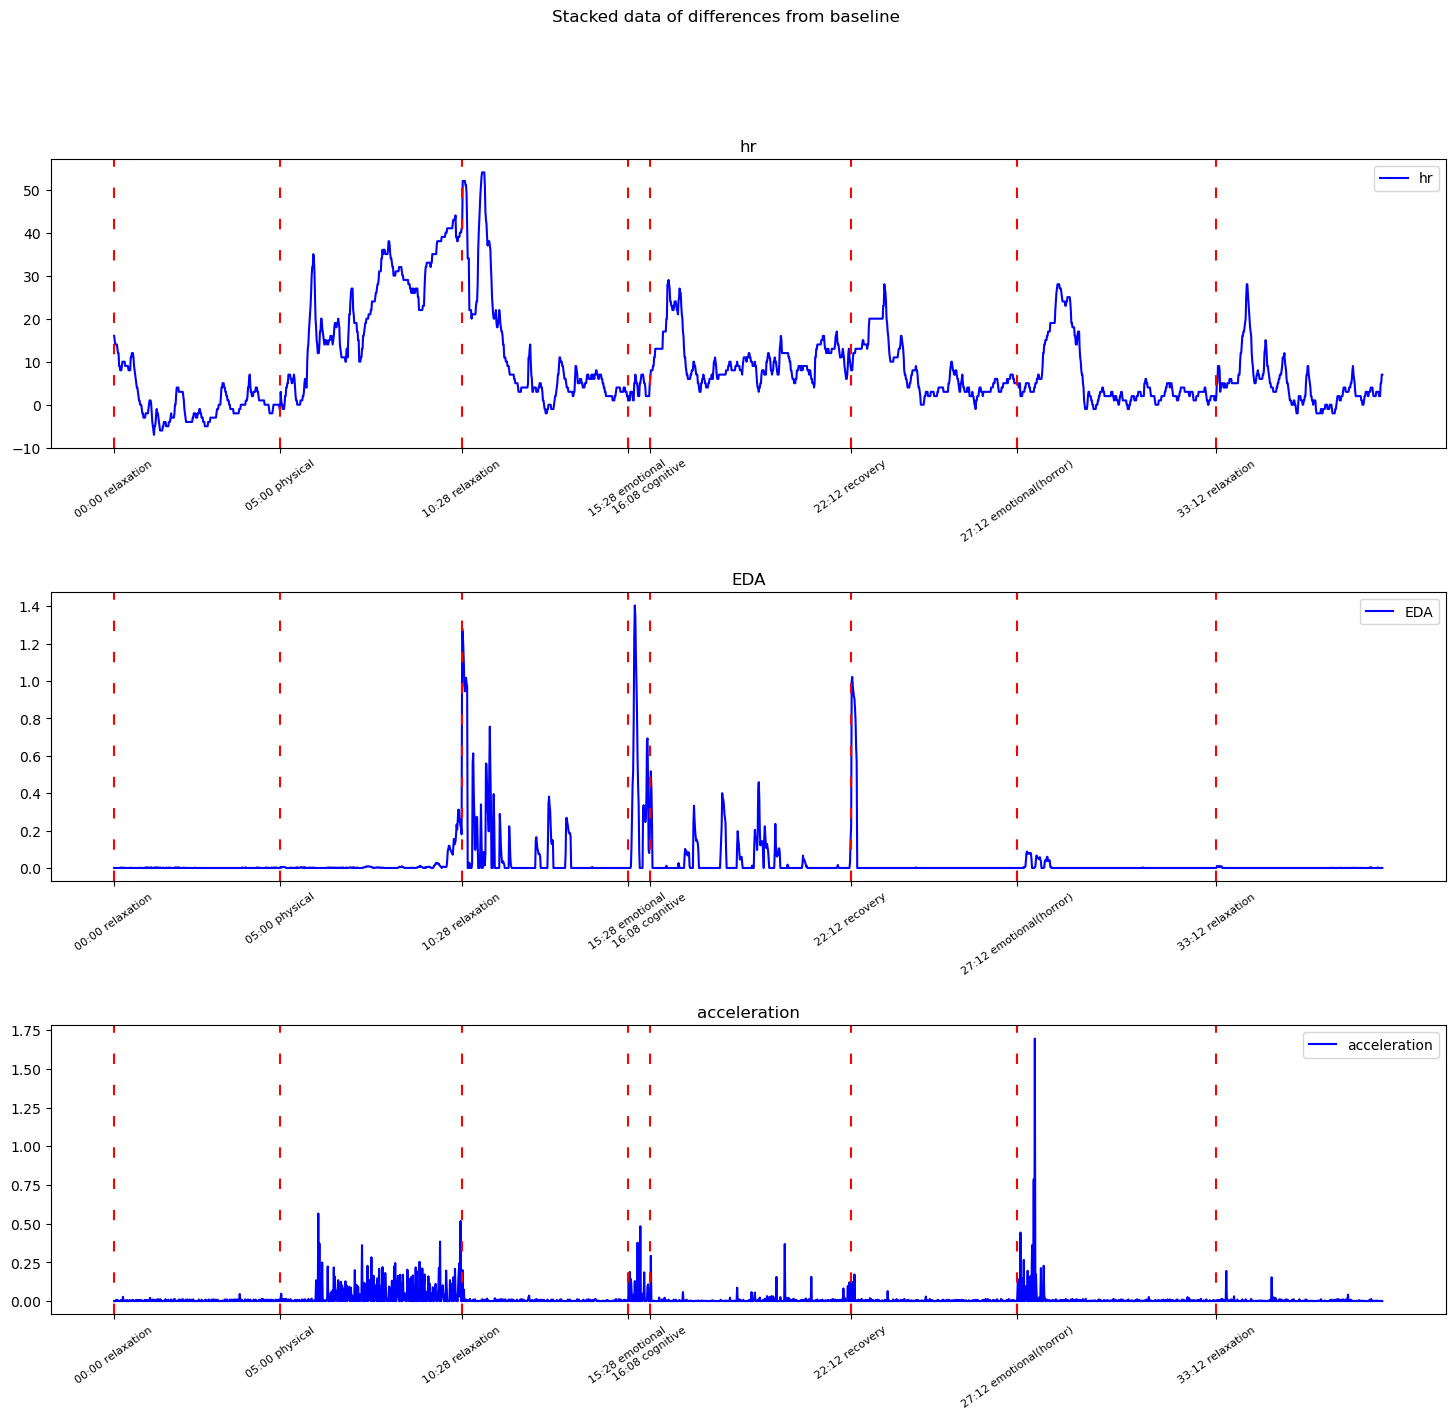

In [9]:
# plot 
def format_time(total_seconds):
    minutes = total_seconds // 60
    seconds = total_seconds % 60
    return f"{minutes:02}:{seconds:02}"

phase_names = ["relaxation", "physical", "relaxation", "emotional", "cognitive", "recovery", "emotional(horror)", "relaxation"]
# add time axis
stacked_preprocessed_data.index = [format_time(i) for i in range(stacked_preprocessed_data.shape[0])]

#make the figsize bigger


fig, axes = plt.subplots(nrows=stacked_preprocessed_data.shape[1])
fig.set_size_inches(18, 10)
fig.subplots_adjust(hspace=0.5)
for index, column in enumerate(stacked_preprocessed_data.columns):
    ax = axes[index]
    ax.plot(stacked_preprocessed_data.index, stacked_preprocessed_data[column])
    ax.lines[0].set_color('b')
    for phase in phases:
        ax.axvline(x=phase, color='r', linestyle='--', dashes=(5, 10))
    
    ax.set_xticks(phases)
    ax.set_xticklabels([format_time(i) + " " + phase_names[index] for index, i in enumerate(phases)], rotation=35, fontsize=8)
    ax.set_title(column)
    ax.legend([column])

fig.set_figheight(15)
fig.suptitle("Stacked data of differences from baseline")
 

(0.0, 0.4)

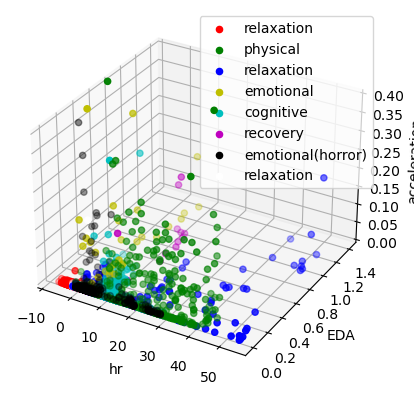

In [21]:
# 3d scatter plot of hr, EDA, acceleration with colors based on phases
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#make a list of colors based on phases
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
for index, phase in enumerate(phases):
    if index == len(phases) - 1:
        ax.scatter(stacked_preprocessed_data['hr'][phase:], stacked_preprocessed_data['EDA'][phase:], stacked_preprocessed_data['acceleration'][phase:], c=colors[index])
    else:
        ax.scatter(stacked_preprocessed_data['hr'][phase:phases[index+1]], stacked_preprocessed_data['EDA'][phase:phases[index+1]], stacked_preprocessed_data['acceleration'][phase:phases[index+1]], c=colors[index])


ax.legend(phase_names)

ax.set_xlabel('hr')
ax.set_ylabel('EDA')
ax.set_zlabel('acceleration')

# set acceleration bounds
ax.set_zlim(0, 0.4)


The data will be characterized for each interval. For more, see cluster.ipynb